# Анализ поведения пользователей мобильного приложения.

**Цель проекта:** анализ потенциального изменения пользовательской активности в результате изменения шрифта в приложении.

**Задачи проекта:**
•	изучить воронку событий;
•	проанализировать A/А-тест;
•	проанализировать A/B-тест;

**Данные:**	логи поведения пользователей.

**Шаг 1. Общая информация о данных** 

In [1]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy import stats as st
import numpy as np
import math as mth
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

In [2]:
#считываем и смотрим данные
data = pd.read_csv('C:\\Users\\Дарья\\Desktop\\Сборный_2\\logs_exp (1).csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
#смотрим общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Шаг 2.  Подготовка данных** 

Пропусков в данных нет. Столбец с данными о дате имеет тип int, менять на datetime не будем, далее добавим столбец с датой с соответствующим типом, используя для преобразования данный столбец. Приведем наименование столбцов к нижнему "змениному" регистру, проверим данные на явные дубликаты.

In [4]:
#переименуем столбцы
#нижний регистр
data.columns = data.columns.str.lower()
data.columns

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')

In [5]:
#"змеиный" регистр
data = data.rename(columns={'eventname': 'event_name', 'deviceidhash': 'device_id_hash',\
                            'eventtimestamp': 'event_timestamp', 'expid': 'exp_id'})
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [6]:
#Проверка на явные дубликаты
data.duplicated().sum()

413

In [7]:
#удаляем дубликаты
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [8]:
#добавляем столбец с датой и временем
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_datetime   243713 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 9.3+ MB


In [9]:
#добавляем столбей с датой
data['event_date'] = data['event_datetime'].astype('datetime64[D]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_datetime   243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


**Шаг 3.  Проверка данных** 

In [10]:
#всего событий в логе
print('Событий в логе: ', data['event_name'].count())

Событий в логе:  243713


In [11]:
#количество пользователей
print('Количество пользователей: ', len(data['device_id_hash'].unique()))

Количество пользователей:  7551


In [12]:
#среднее количество событий на пользователя
print('Среднее количество событий на пользователя: ', round(data['event_name'].count()/len(data['device_id_hash'].unique())))

Среднее количество событий на пользователя:  32


In [13]:
print('Максимальная дата лога:', data['event_date'].max())

Максимальная дата лога: 2019-08-07 00:00:00


In [14]:
print('Минимальная дата лога:', data['event_date'].min())

Минимальная дата лога: 2019-07-25 00:00:00


Располагаем событиями за период с 25.07.2019 по 07.08.2019 г. Посмотрим на распределение данных по дате и времени.

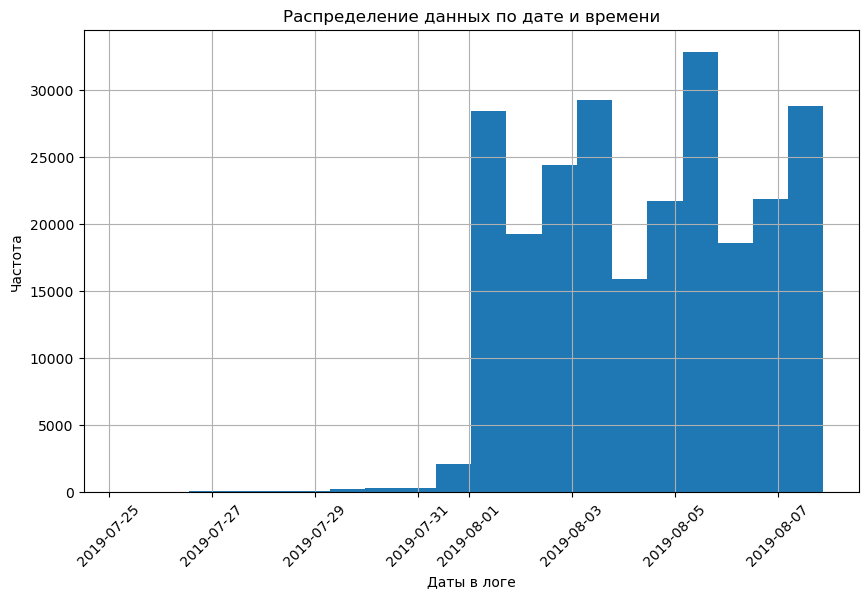

In [15]:
#рисуем гистограмму
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
plt.title('Распределение данных по дате и времени')
plt.xlabel('Даты в логе')
plt.ylabel('Частота')
data['event_datetime'].hist(bins=20);

Технически в логи новых дней по некоторым пользователям могут дозаписываться события из прошлого, что мы скорее всего и видим на графике - за июль очень мало данных. Для анализа оставим данные с 1 августа.

In [16]:
#фильтруем
data_filtered = data.query('event_date >= "2019-08-01"')
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   exp_id           240887 non-null  int64         
 4   event_datetime   240887 non-null  datetime64[ns]
 5   event_date       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


Посмотрим что осталось в данных.

In [17]:
#количество "потерянных" событий
print('Kоличество "потерянных" событий: ', data['event_name'].count() \
      - data_filtered['event_name'].count())

Kоличество "потерянных" событий:  2826


In [18]:
#процент "потерянных" событий
print('Процент "потерянных" событий: ', round((data['event_name'].count() - data_filtered['event_name'].count())*100 \
      /data['event_name'].count(), 1))

Процент "потерянных" событий:  1.2


In [19]:
#количество "потерянных" пользователей
print('Количество "потерянных" пользователей: ', len(data['device_id_hash'].unique()) - len(data_filtered['device_id_hash'].unique()))

Количество "потерянных" пользователей:  17


In [20]:
#процент "потерянных" пользователей
print('Процент "потерянных" пользователей: ', round((len(data['device_id_hash'].unique()) - len(data_filtered['device_id_hash'].unique()))*100 \
      /len(data['device_id_hash'].unique()), 1), '%')

Процент "потерянных" пользователей:  0.2 %


Проверим участие оставшихся пользователей во всех трех группах.

In [21]:
data_filtered['exp_id'].unique()

array([246, 247, 248], dtype=int64)

Пользователи распределены по трем группам.

**Шаг 4. Воронка событий** 

In [22]:
#события в логах
data_filtered['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [23]:
#воронка событий
data_funnel = data_filtered.groupby('event_name').agg({'device_id_hash': 'nunique'}).\
sort_values(by='device_id_hash', ascending=False).reset_index()
data_funnel.columns = ['event_name', 'device_id_hash_count']
data_funnel['perc_users'] = round(data_funnel['device_id_hash_count']*100\
                                  /data_filtered['device_id_hash'].nunique(),1)
data_funnel

,event_name,device_id_hash_count,perc_users
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


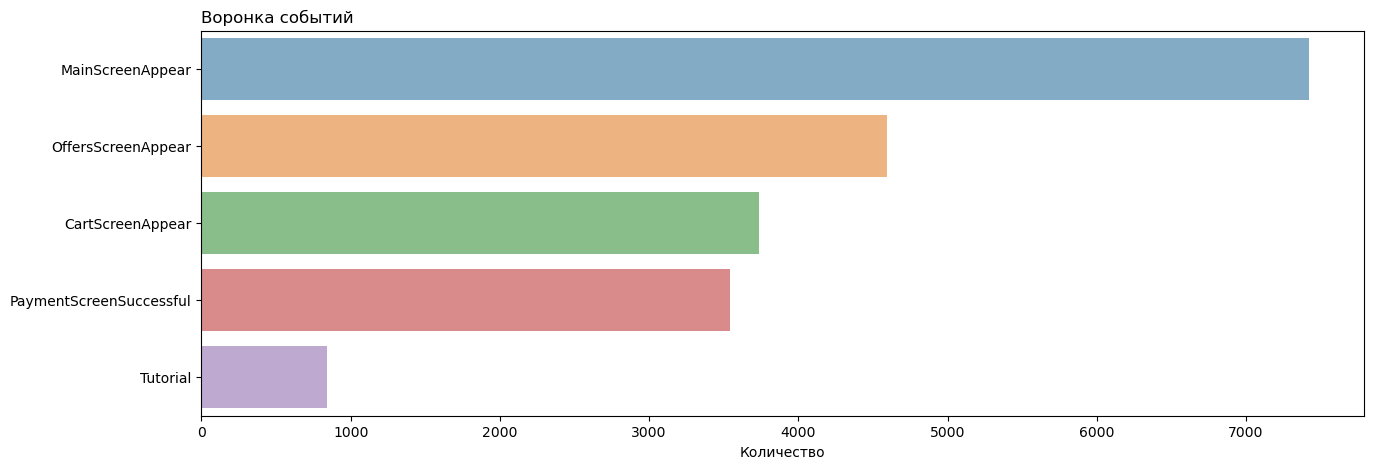

In [24]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='device_id_hash_count', y='event_name', data=data_funnel, alpha=0.6, orient='h')
ax.set_title('Воронка событий', loc='Left')
ax.set_xlabel('Количество') 
ax.set_ylabel('') 
plt.show()

Предполагаю, что данные события должны происходить в следующем порядке: MainScreenAppear --> Tutorial --> OffersScreenAppear --> CartScreenAppear --> PaymentScreenAppear. При этом, по количеству пользователей, совершающих каждое событие, видим, что Tutorial  занимает логически-непоследовательное место в цепочке: только 11% пользователей, увидевших главную страницу сайта, проходят "обучение"(возможно речь идет о правилах использования сайта). Т.о., событие Tutorial исключаем из расчёта воронки.

In [25]:
data_funnel = data_filtered.query('event_name != "Tutorial"').groupby('event_name').\
agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False).reset_index()
data_funnel.columns = ['event_name', 'device_id_hash_count']
data_funnel['perc_users'] = round(data_funnel['device_id_hash_count']*100\
                                  /data_filtered['device_id_hash'].nunique(),1)
data_funnel

,event_name,device_id_hash_count,perc_users
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0


In [26]:
#считаем доли пользователей, проходящих на следующий шаг воронки (столбец perc_save_users)
warnings.filterwarnings('ignore') # отключаем предупреждения
data_funnel['perc_save_users'] = ""
for i in range(1, len(data_funnel['event_name'])):
    data_funnel['perc_save_users'][i] = round(data_funnel['device_id_hash_count'][i]*100/data_funnel['device_id_hash_count'][i-1])
data_funnel    

,event_name,device_id_hash_count,perc_users,perc_save_users
0,MainScreenAppear,7419,98.5,
1,OffersScreenAppear,4593,61.0,62
2,CartScreenAppear,3734,49.6,81
3,PaymentScreenSuccessful,3539,47.0,95


Больше всего пользователей теряется на переходе с главного экрана на экран предложений. Посчитаем долю пользователей, доходящих от первого события до оплаты.

In [27]:
print('Доля пользователей, доходящих до оплаты:', \
      round(data_funnel['device_id_hash_count'][3]*100 / data_funnel['device_id_hash_count'][0]))

Доля пользователей, доходящих до оплаты: 48


**Шаг 5. Результаты эксперимента** 

*5.1 Количество пользователей в каждой экспериментальной группе* 

In [28]:
user_exp = data_filtered.groupby('exp_id').agg({'device_id_hash': 'nunique'})
user_exp

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


*5.2 Разница статитических критериев выборок 246 и 247* 

In [29]:
#различия в количестве участников
print('Группы 246 и 247 по количеству участников отличаются на',\
      round((1 - user_exp.loc[246,'device_id_hash']/user_exp.loc[247,'device_id_hash'])*100,2),'%')

Группы 246 и 247 по количеству участников отличаются на 1.15 %


In [30]:
#участие пользователей в нескольких группах
data_filtered.groupby('device_id_hash').agg({'exp_id': 'nunique'}).query('exp_id > 1')

,exp_id
device_id_hash,


Разница в количестве пользователей в группах ~1%. Нет пользователей, учавствующих в эксперименте в нескольких группах. Будем считать приемлемыми статистические критерии различий между контрольными группами.

*5.3 A/A - тест* 

In [31]:
#популярное событие
event_exp = data_filtered.pivot_table(index='event_name', columns='exp_id',\
                                      values='device_id_hash',aggfunc='nunique').\
sort_values(246,ascending=False)
event_exp

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Самое популярное событие MainScreenAppear  - просмотр главного экрана.

In [32]:
#исключим Tutorial из событий
event_exp = data_filtered.query('event_name != "Tutorial"').\
pivot_table(index='event_name', columns='exp_id', values='device_id_hash',aggfunc='nunique').\
sort_values(246,ascending=False)
event_exp

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


Для проверки статистически значимой разницы между группами будем использовать z-критерий (проверка гипотезы о равенстве долей). Проверки делаем с помощью функции.

In [33]:
#функция func_test попарно проверят группы на наличие статистической значимости в разнице долей.
#входящие параметры - номера групп, наименование события, критический уровень стат.значимости
def func_test (gr_1, gr_2, event, alpha):
    #срезы событий по группам
    exp1_event = event_exp.loc[event, gr_1]
    exp2_event = event_exp.loc[event, gr_2]
    #срезы пользователей по группам
    exp1_user = user_exp.loc[gr_1,'device_id_hash']
    exp2_user = user_exp.loc[gr_2,'device_id_hash']
    #пропорция успехов в первой группе
    p1 = exp1_event/exp1_user
    #пропорция успехов во второй группе
    p2 = exp2_event/exp2_user
    # пропорция успехов в комбинированном датасете:
    p_combined = (exp1_event + exp2_event) / (exp1_user + exp2_user)
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/exp1_user + 1/exp1_user))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Группы', gr_1, ',', gr_2,', ' 'событие -', event,',','p_value=', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print('-----------------------------------------------------------------------------------')

Сформулируем гипотезы: 
H0: Нет статистически значимых различий между долями посетителей на каждом этапе воронки;
H1: Есть статистически значимые разлиия между долями посетителей на каждом этапе воронки. 
Критический уровень значимости alpha примем за 5%.

In [34]:
#оцениваем различия 246 и 247 групп
for event in event_exp.index:
    func_test(246, 247, event, 0.05)
print()

Группы 246 , 247 , событие - MainScreenAppear , p_value= 0.7577396085731218
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 247 , событие - OffersScreenAppear , p_value= 0.24946461553251353
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 247 , событие - CartScreenAppear , p_value= 0.23018135023865005
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 247 , событие - PaymentScreenSuccessful , p_value= 0.11561795424626342
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------



Статистически значимых различий между группами нет, можно считать A/A - тест состоявшимся.

*5.4 A/B - тест* 

Сформулируем гипотезы: 
H0: Нет статистически значимых различий между долями посетителей на каждом этапе воронки;
H1: Есть статистически значимые разлиия между долями посетителей на каждом этапе воронки. 
Критический уровень значимости alpha примем за 5%.
Для расчетов применим ту же функцию.

In [35]:
#оцениваем различия 246 и 248 групп
for event in event_exp.index:
    func_test(246, 248, event, 0.05)
print()

Группы 246 , 248 , событие - MainScreenAppear , p_value= 0.29750800181940074
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 248 , событие - OffersScreenAppear , p_value= 0.21075419390712913
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 248 , событие - CartScreenAppear , p_value= 0.08000480013369082
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 248 , событие - PaymentScreenSuccessful , p_value= 0.21465895373507626
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------



Различий нет для каждого события.

In [36]:
#оцениваем различия 247 и 248 групп
for event in event_exp.index:
    func_test(247, 248, event, 0.05)
print()

Группы 247 , 248 , событие - MainScreenAppear , p_value= 0.4597698698524082
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 247 , 248 , событие - OffersScreenAppear , p_value= 0.9199710848537843
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 247 , 248 , событие - CartScreenAppear , p_value= 0.5795194253074443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 247 , 248 , событие - PaymentScreenSuccessful , p_value= 0.7379405386465885
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------



Различий нет для каждого события.

Подготовим датафреймы для проверки отличия между объединенной контрольной группой и тестируемой.

In [37]:
#к датафрейму пользователей добавим строку
#user_exp = user_exp.reset_index()
#user_exp.loc[len(user_exp.index)] = ['246+247', 4997]
#user_exp

In [38]:
#делаем датафрейм пользователей с объединенной группой
user_exp = data_filtered.pivot_table(index='exp_id', columns = [], values='device_id_hash', \
                          aggfunc='nunique', margins=True).reset_index()
user_exp.loc[user_exp['exp_id']=='All', 'device_id_hash'] = 4997
user_exp = user_exp.set_index(user_exp.columns[0])
user_exp = user_exp.rename(index = {'All': '246+247'})
user_exp

,device_id_hash
exp_id,
246,2484
247,2513
248,2537
246+247,4997


In [39]:
#возвращаем прежнюю индексацию, чтобы не менять правила формирования срезов в функции
#user_exp = user_exp.set_index(user_exp.columns[0])
#user_exp

In [40]:
#к датафрейму событий добавим столбец
event_exp['246+247'] = event_exp[246] + event_exp[247]
event_exp

exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [41]:
#оцениваем различия объединенной контрольной и тестируемой групп
for event in event_exp.index:
    func_test('246+247', 248, event, 0.05)
print()

Группы 246+247 , 248 , событие - MainScreenAppear , p_value= 0.20122679941423627
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246+247 , 248 , событие - OffersScreenAppear , p_value= 0.34068706882533895
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246+247 , 248 , событие - CartScreenAppear , p_value= 0.1036987627244148
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246+247 , 248 , событие - PaymentScreenSuccessful , p_value= 0.5233126643495414
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------



Различий нет - изменение шрифта в приложении никак не повлияло на поведение пользователей.

*5.5 Уровень значимости* 

В ходе эксперимента было проведено 16 проверок статистических гипотез. При увеличении количества таких тестов, возрастает вероятность ложноположительного результата. Чтобы её снизить, можно применить метод Бонферони. Он заключается в уменьшении уровня значимости во столько раз, сколько тестов было проведено. При этом все тесты должны быть проведены без сбора новых данных, что в рамках нашего тестирования выполняетя. Т.о., alpha: 0.05/16 = 0.003. Проведем новые проверки.  

In [42]:
#оцениваем различия 246 и 247 групп
for event in event_exp.index:
    func_test(246, 247, event, 0.003)
print()

Группы 246 , 247 , событие - MainScreenAppear , p_value= 0.7577396085731218
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 247 , событие - OffersScreenAppear , p_value= 0.24946461553251353
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 247 , событие - CartScreenAppear , p_value= 0.23018135023865005
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 247 , событие - PaymentScreenSuccessful , p_value= 0.11561795424626342
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------



In [43]:
#оцениваем различия 246 и 248 групп
for event in event_exp.index:
    func_test(246, 248, event, 0.003)
print()

Группы 246 , 248 , событие - MainScreenAppear , p_value= 0.29750800181940074
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 248 , событие - OffersScreenAppear , p_value= 0.21075419390712913
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 248 , событие - CartScreenAppear , p_value= 0.08000480013369082
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246 , 248 , событие - PaymentScreenSuccessful , p_value= 0.21465895373507626
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------



In [44]:
#оцениваем различия 247 и 248 групп
for event in event_exp.index:
    func_test(247, 248, event, 0.003)
print()

Группы 247 , 248 , событие - MainScreenAppear , p_value= 0.4597698698524082
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 247 , 248 , событие - OffersScreenAppear , p_value= 0.9199710848537843
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 247 , 248 , событие - CartScreenAppear , p_value= 0.5795194253074443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 247 , 248 , событие - PaymentScreenSuccessful , p_value= 0.7379405386465885
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------



In [45]:
#оцениваем различия 246+247 и 248 групп
for event in event_exp.index:
    func_test('246+247', 248, event, 0.003)
print()

Группы 246+247 , 248 , событие - MainScreenAppear , p_value= 0.20122679941423627
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246+247 , 248 , событие - OffersScreenAppear , p_value= 0.34068706882533895
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246+247 , 248 , событие - CartScreenAppear , p_value= 0.1036987627244148
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------
Группы 246+247 , 248 , событие - PaymentScreenSuccessful , p_value= 0.5233126643495414
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------------



 Ни один тест с новой поправкой не выявил различий. И всё-таки - шрифт никак не влияет на пользовательскую активность. 

**Выводы:**
В результате анализа поведения пользователей приложения, результатов А/А/В-теста были получены следующие результаты:

1. Больше всего пользователей "терялось" после первого шага (38%).
2. 48% пользователей прошли всю воронку событий и оплатили заказ.
3. А/А-тест эксперимента (изменение шрифта во всем приложении) показал отсутствие различий в контрольных группах по каждому событию.
4. А/В-тесты также показали отсутствие различий в контрольных группах по каждому событию.
5. Уменьшение уровня значимости методом Бонферони не привело к изменению результатов ни по одному тесту. 
6. Т.о., можно сделать вывод о том, что эксперимент по изменению шрифта в приложении не стал успешным.